## Min, mean and max crustal carbon grids
This routine is parallelised with `joblib`'s `LokyBackend` 


In [1]:
from joblib import Parallel, delayed
import numpy as np
import pygplates
import ptt
import gplately
from gplately import tools
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader

import netCDF4
import warnings
from scipy import ndimage
from scipy.interpolate import RegularGridInterpolator
import os, glob
import pandas as pd

### Define directories

In [2]:
# Don't change this - Output path to save crustal carbon grids to
output_path = "../Muller2022_InputGrids/CrustalCarbon/"
os.makedirs(output_path, exist_ok=True)

# --------------- Everything below here can be kept as-is ----------------
grid_directory = "../Muller2022_InputGrids/SeafloorAge"
agegrid_path = grid_directory+"/Muller2022_SEAFLOOR_AGE_grid_{:.1f}Ma.nc"

# Change `folder_name`: a string to name a new sub-folder for a new set of Notebook 1 outputs; 
# useful for keeping track of reruns
folder_name = "Muller22_Mar2"

# Don't change this: directory to input files
fig_dir = "../Outputs/{}/Others/".format(folder_name)
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(fig_dir+"/figures", exist_ok=True)

In [3]:
import sys
lookup_table_directory = "./crustal_CO2_model_computation/"
sys.path.insert(0, lookup_table_directory)

from oceanic_crustal_co2 import create_co2_grid

In [4]:
# Path to temperature-time series table
age_temp_series_path = lookup_table_directory+"age_deep-ocean-temp_1ga.txt"

# Path to bilinear log lookup table
co2_water_temperature_lookup_table_path = lookup_table_directory+"age_bwt_co2_model_{}_bilinear_log.nc"

### Define time parameters

In [5]:
# Averaging time window
average_time_range = 20

min_time = 0
max_time = 1000
timestep_size = 1
reconstruction_times = np.arange(min_time, max_time+timestep_size, timestep_size)

### A plot of temperature through time

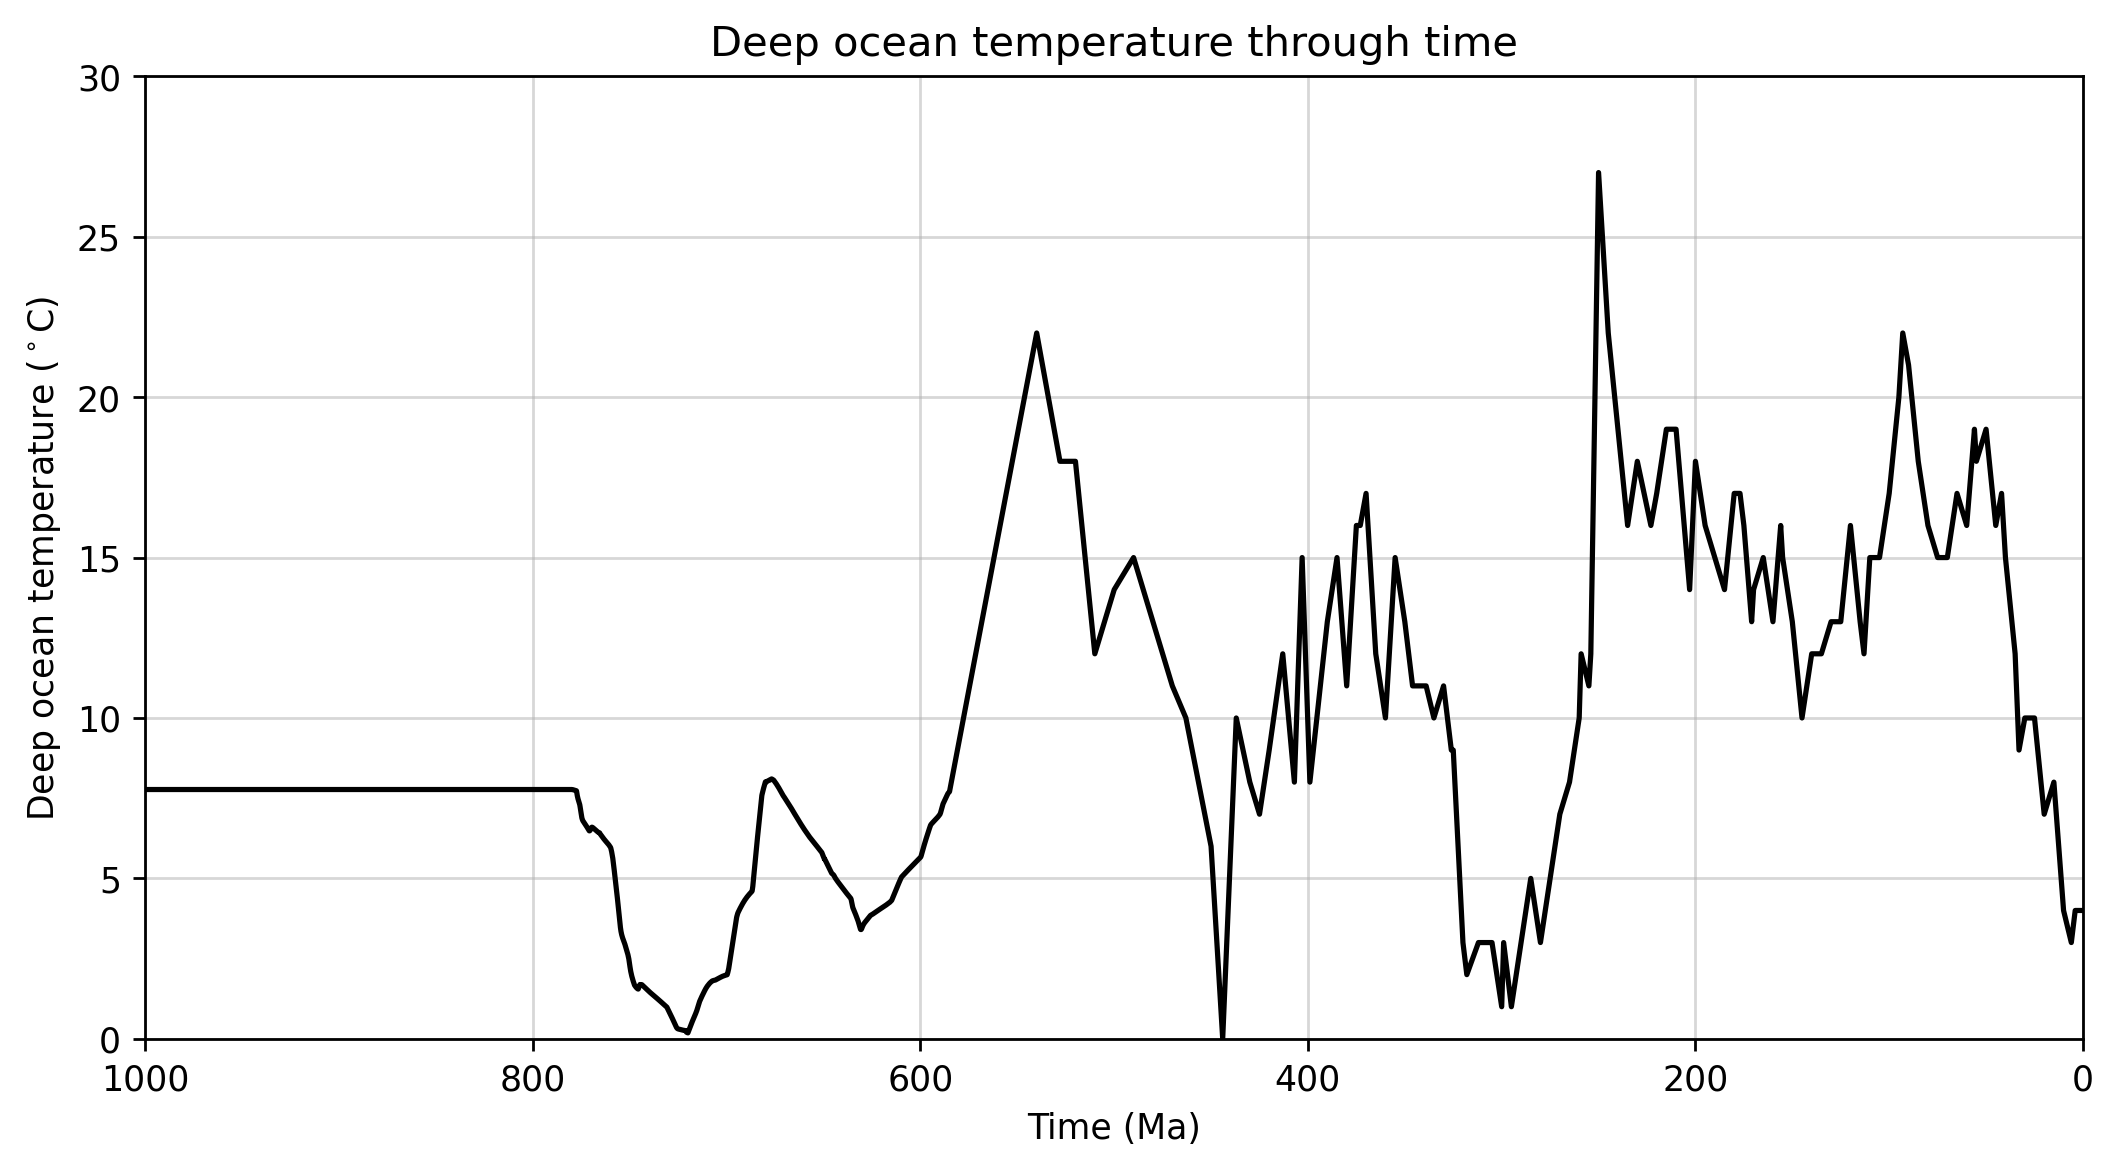

In [8]:
pd.read_table(age_temp_series_path)

temp_df = pd.read_table(age_temp_series_path, names=["Age", "DeepOceanTemp", "NaNs"]).iloc[1:].astype(float)
temp_df = temp_df.iloc[:, temp_df.columns != 'NaNs']

ages = temp_df['Age'].to_numpy()
ocean_temp = temp_df['DeepOceanTemp'].to_numpy()

# smoothed_ocean_temp = gplately.tools.smooth_1D_gaussian(ocean_temp,15)

fig = plt.figure(figsize=(10,5), dpi=250)
plt.plot(ages, ocean_temp, color='k')
plt.xlim([1000,0])
plt.ylim([0,30])
plt.grid(alpha=0.5)
plt.title("Deep ocean temperature through time")
plt.xlabel("Time (Ma)")
plt.ylabel("Deep ocean temperature ($^\circ$C)")
plt.show()

save_fig = True
if save_fig:
    fig.savefig(fig_dir+"/figures/deep_ocean_temp.pdf", bbox_inches='tight', dpi=300)
    fig.savefig(fig_dir+"/figures/deep_ocean_temp.svg", bbox_inches='tight', dpi=300)
    fig.savefig(fig_dir+"/figures/deep_ocean_temp.png", bbox_inches='tight', dpi=300)

### Produce min, mean and max crustal carbon grids
This uses joblib's LokyBackend three times to produce grids for each of the three quantities: `min`, `mean` and `max`.

In [7]:
for mode in ["min", "mean", "max"]:
    Parallel(n_jobs=-2, verbose=1)(
        delayed(create_co2_grid)(reconstuction_time,
        age_temp_series_path,
        agegrid_path.format(reconstuction_time),
        co2_water_temperature_lookup_table_path.format(mode),
        output_path,
        mode,
        average_time_range) for reconstuction_time in reconstruction_times)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed: 56.7min
[Parallel(n_jobs=-2)]: Done 1001 out of 1001 | elapsed: 65.7min finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-2)]: Done 1001 out of 1001 | elapsed: 39.4min finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:  6.3min
[Paral

Plot 1x min, mean and max grid to check how they look:

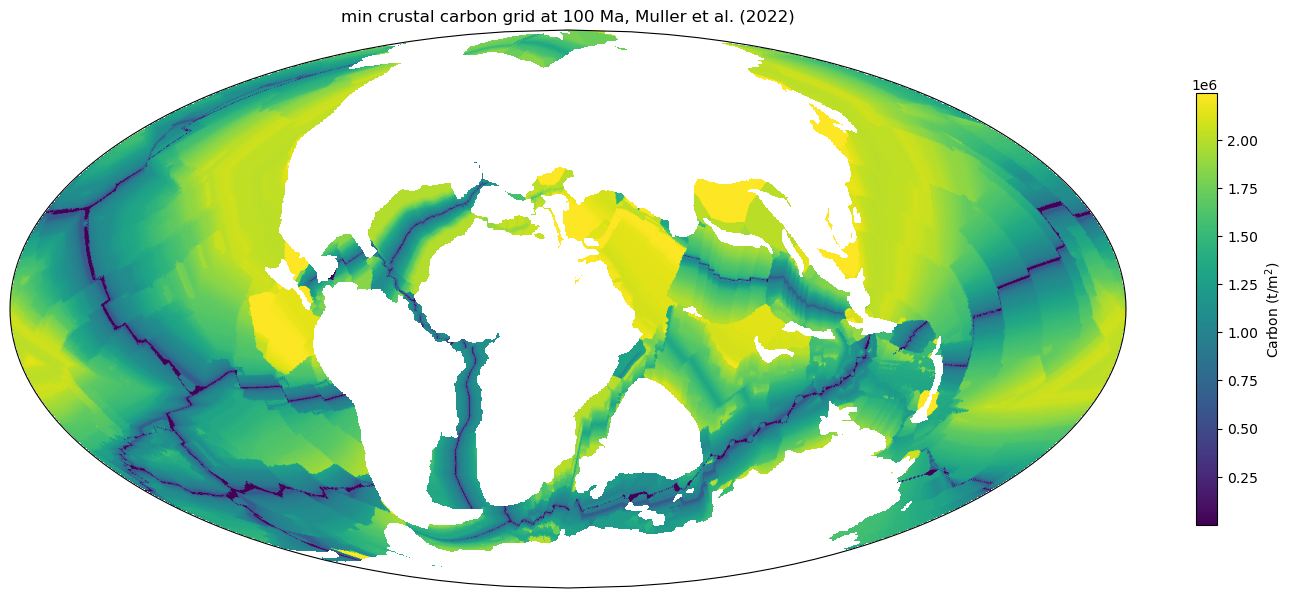

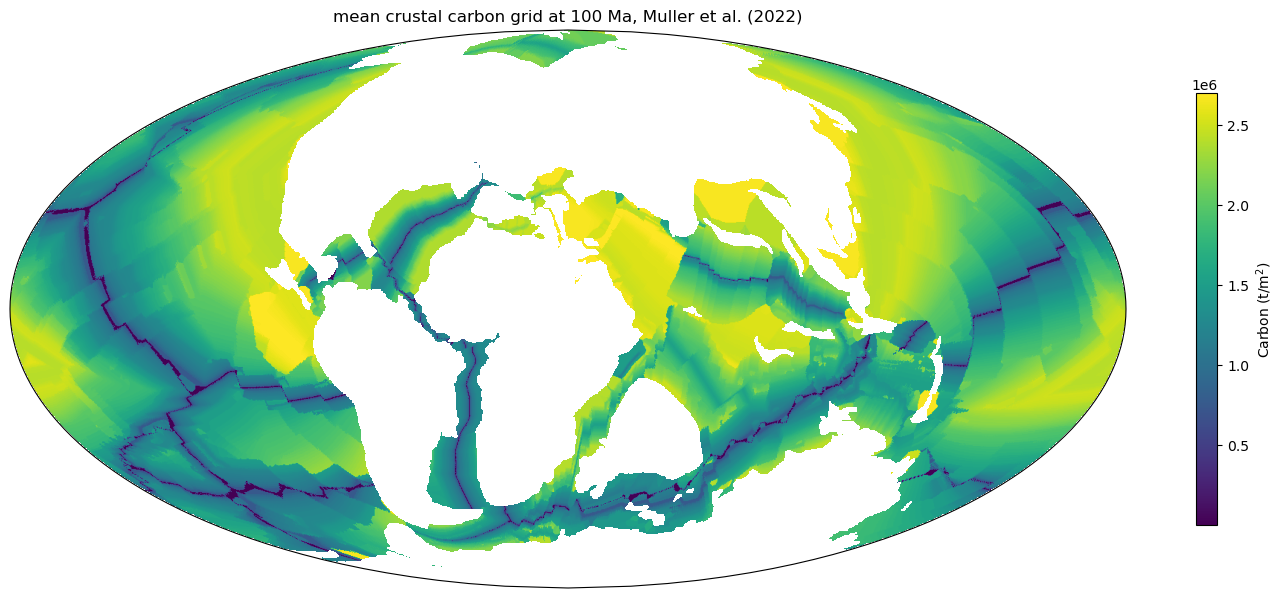

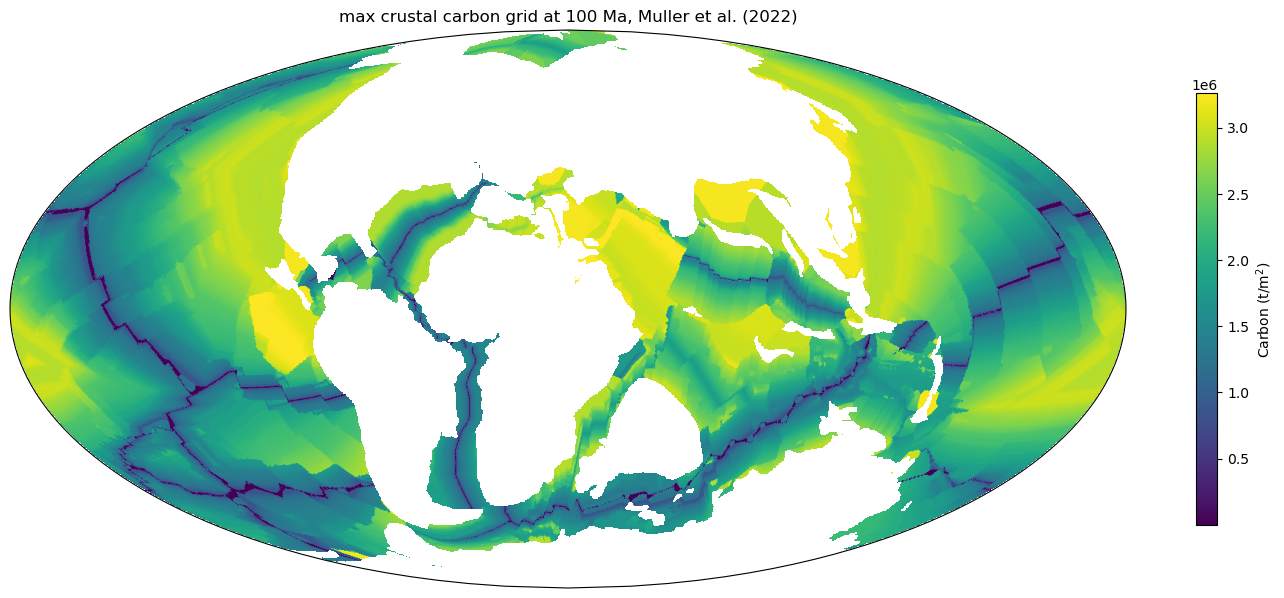

In [8]:
# Set up plot
crustalgrid_path = output_path+"/{}/{}/upper_crustal_CO2_{}_{}.nc"

def plot_crustal_carbon(crustalgrid_path, time):
    
    fig = plt.figure(figsize=(18,14), dpi=100)
    ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 20))
    ax1.set_title("{} crustal carbon grid at {} Ma, Muller et al. (2022)".format(mode, time))
    
    im = plt.imshow(
        gplately.grids.Raster(filename=crustalgrid_path.format(mode, time, mode, time)).data*1e6,
        origin="lower", transform=ccrs.PlateCarree()
    )
    
    fig.colorbar(im, shrink=0.4, label='Carbon (t/m$^2$)')
    
    ax1.set_global()
    
    # plt.savefig(output_path+"/{}/upper_crustal_CO2_{}.png".format(time, time))
    return


for mode in ["min", "mean", "max"]:
    for time in [100]:
        plot_crustal_carbon(crustalgrid_path.format(mode, time, mode, time), time)